In [ ]:
# 1 run this cell and select kaggle.json file download form the a kaggle account settings pages
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dermotkeaney","key":"9657a6ed70685537f780768013d27606"}'}

We will start by connecting to Kaggle using Kaggle API which can be downloaded from your kaggle account's settings and uploading it to Colab

In [ ]:
# Next install the kaggle API client
!pip install -q kaggle


Installing kaggle api using pip

In [ ]:
# The Kaggle API client expects this file to be in  ~/.kaggle,so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change aviods a warning on Kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

Setting up Kaggle using Kaggle API

In [ ]:
# Creating directory and changing the current working directory
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


To store the data we will create a new directory and make it as current working directory

In [ ]:
# Searching for dataset

!kaggle datasets list -s gtsrb-german-traffic-sign

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34          99477       1061  0.8235294        
valentynsichkar/traffic-signs-preprocessed                         Traffic Signs Preprocessed                           4GB  2019-08-31 18:22:11          13019        277  1.0              
harbhajansingh21/german-traffic-sign-dataset                       German Traffic Sign Dataset                        118MB  2023-07-11 04:21:24            498         30  1.0              
ibrahimkaratas/gtsrb-german-traffic-sign-recogniti

Searching Kaggle for the required dataset using search option(-s) with title 'gtsrb-german-traffic-sign

In [ ]:
#Downloading dataset and coming out of directory

!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
%cd ..

100% 609M/612M [00:07<00:00, 111MB/s]
100% 612M/612M [00:07<00:00, 84.7MB/s]
/content


After searching the data next step would be downloading the data into collab notebook using references found in search option

In [ ]:
# Unzipping downloaded file and removing the ususable file
!unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset
!rm traffic_sign_dataset/gtsrb-german-traffic-sign.zip
#!rm -rf traffic_sign_dataset/Meta
#!rm -rf traffic_sign_dataset/meta
#!rm -rf traffic_sign_dataset/test
#!rm -rf traffic_sign_dataset/train
#!rm traffic_sign_dataset/Meta.csv


Streaming output truncated to the last 5000 lines.
  inflating: traffic_sign_dataset/train/5/00005_00053_00010.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00011.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00012.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00013.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00014.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00015.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00016.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00017.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00018.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00019.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00020.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00021.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00022.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00023.png  
  inflating: traffic_sign

We will unzip the data which is downloaded and remove the irrelevant files

In [ ]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

Importing required libraries

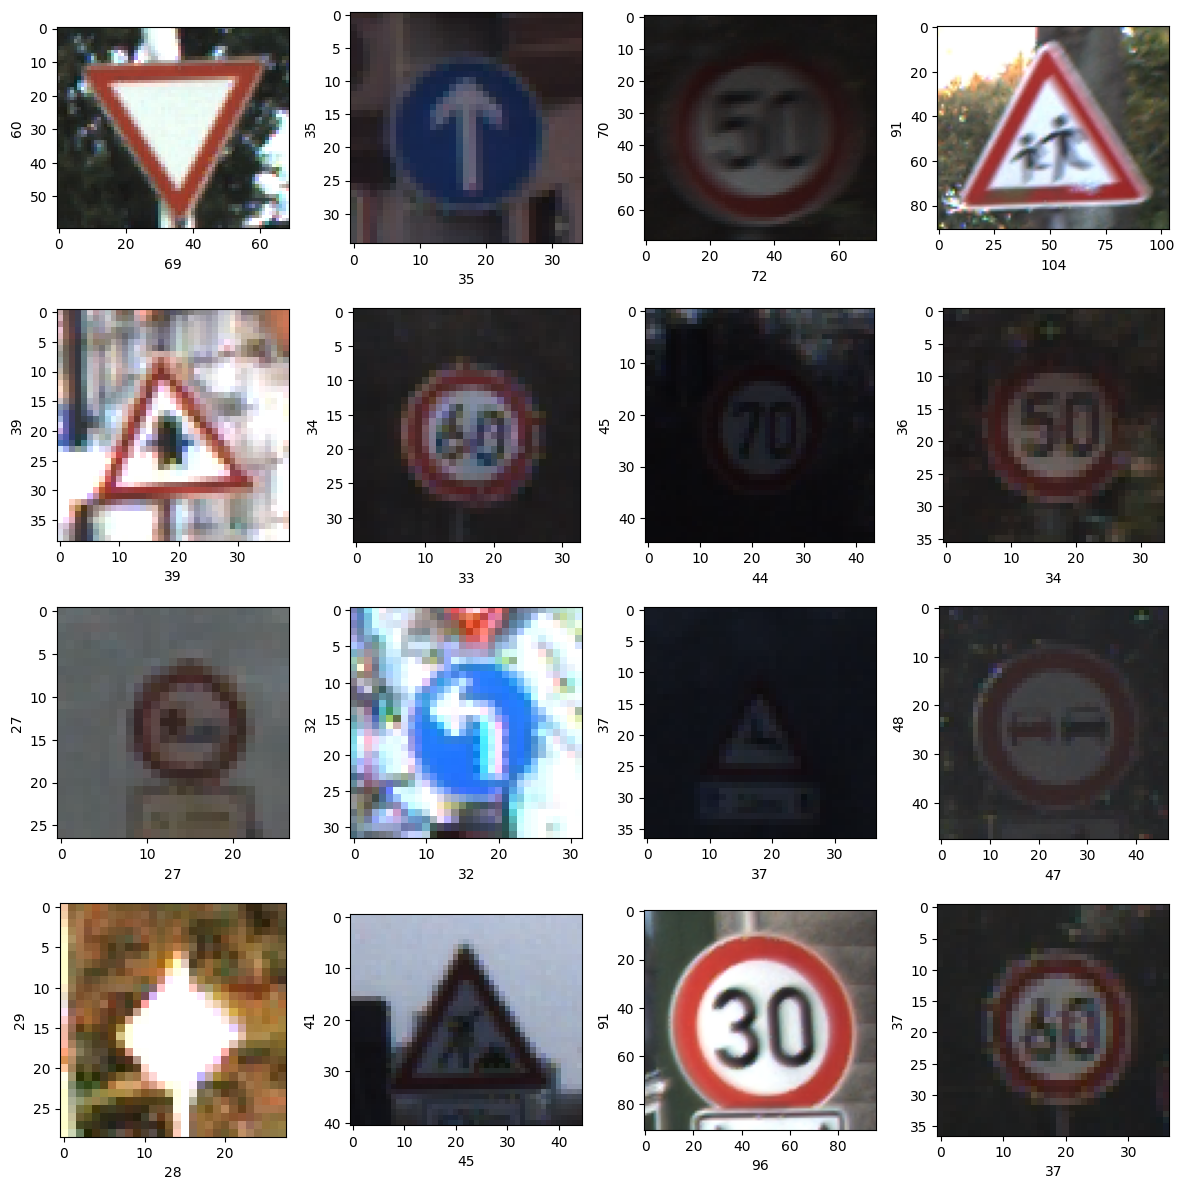

In [ ]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "traffic_sign_dataset/Test"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

Visualizing some images of traffic sign from the test dataset. we can see here that the dimension of images are uneven.

In [ ]:
# As size of images are different we have to make them equal so we will take mean of dimensions
dim1 = []
dim2 = []

for i in range(0,43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

For further processing we will require the images of same dimension. So, we will start storing the dimension of all the images from training dataset from all 43 classes.

In [ ]:
#Printing mean dimension of images
print("Dimension 1 Mean : ",np.mean(dim1), " Dimension 2 Mean : ",np.mean(dim2))

Dimension 1 Mean :  50.328929582493814  Dimension 2 Mean :  50.83587951745773


Now we will find out the mean value of both the dimensions and analyse them. Here, we can see that (50,50) is the average shape for all the images.

In [ ]:
# Now we will reshape the images to (50,50)
images = []
label_id = []

for i in range(43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = Image.open(labels + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)
        label_id.append(i)

Now we will reshape the images into (50,50) and also store their label ids.

In [ ]:
#Converting images into numpy array
images = np.array(images)
#The pixel value of each image ranges between 0 and 255
#Dividing each image by 255 will scale the values between 0 and 1. This is normalisation.
images = images/255

Now we will convert all the images into numpy array and normalize them.

In [ ]:
label_id = np.array(label_id)
label_id.shape

(39209,)

Storing the label ids into numpy array and printing the shape. Here we can observe that their are 39209 label ids.

In [ ]:
images.shape

(39209, 50, 50, 3)

Checking the shape of the images. Here we can see that their are 39209 images with a shape of (50,50,3.)

In [ ]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_id).value_counts()
label_counts.head()  #showing the first five rows

2     2250
1     2220
13    2160
12    2100
38    2070
dtype: int64

Now we will observe images per class for checking whether the data is balanced or not. From the result we can say that data is balanced.

In [ ]:
#Splitting the data
x_train, x_val, y_train, y_val = train_test_split(images, label_id , test_size = 0.2, random_state = 42)

The next step would be to split the data into training and validation with 80% of training data and 20% of validation data.

In [ ]:
#keras has a built-in function for one-hot encoding.
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (50, 50)
BATCH_SIZE = 32

train_dir = "traffic_sign_dataset/Train/"
test_dir = "traffic_sign_dataset/Test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 39209 images belonging to 43 classes.
Testing images:
Found 0 images belonging to 0 classes.


Converting the classes column into categorical using to_categorical() function.

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax'))

Defining the model architecture. In this we will define all the layers with their input shape kernel size, activation, etc.

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0

Compiling the model using metrics, optimizer and loss as required and printing out the summary of the model.

In [ ]:
model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_data = (x_val, y_val), verbose = 2)

Epoch 1/10
246/246 - 12s - loss: 2.4644 - accuracy: 0.3193 - val_loss: 1.2784 - val_accuracy: 0.6599 - 12s/epoch - 47ms/step
Epoch 2/10
246/246 - 5s - loss: 1.1846 - accuracy: 0.6232 - val_loss: 0.4940 - val_accuracy: 0.8854 - 5s/epoch - 18ms/step
Epoch 3/10
246/246 - 5s - loss: 0.7827 - accuracy: 0.7458 - val_loss: 0.2933 - val_accuracy: 0.9424 - 5s/epoch - 19ms/step
Epoch 4/10
246/246 - 5s - loss: 0.5981 - accuracy: 0.8079 - val_loss: 0.2192 - val_accuracy: 0.9651 - 5s/epoch - 19ms/step
Epoch 5/10
246/246 - 5s - loss: 0.5160 - accuracy: 0.8307 - val_loss: 0.1543 - val_accuracy: 0.9733 - 5s/epoch - 19ms/step
Epoch 6/10
246/246 - 5s - loss: 0.4283 - accuracy: 0.8634 - val_loss: 0.1372 - val_accuracy: 0.9746 - 5s/epoch - 19ms/step
Epoch 7/10
246/246 - 5s - loss: 0.3888 - accuracy: 0.8752 - val_loss: 0.1127 - val_accuracy: 0.9786 - 5s/epoch - 19ms/step
Epoch 8/10
246/246 - 4s - loss: 0.3602 - accuracy: 0.8824 - val_loss: 0.1048 - val_accuracy: 0.9770 - 4s/epoch - 18ms/step
Epoch 9/10
246

Now we will fit the model and observe how our is getting trained on each epoch.

<Axes: >

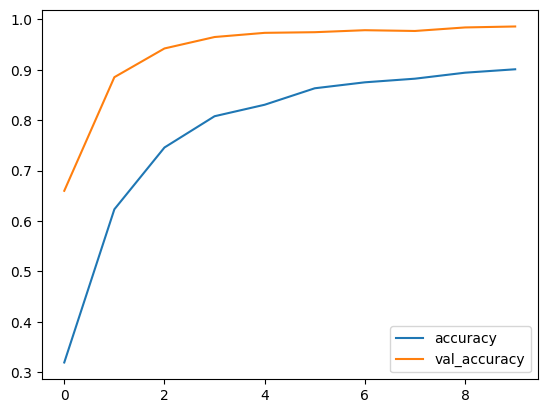

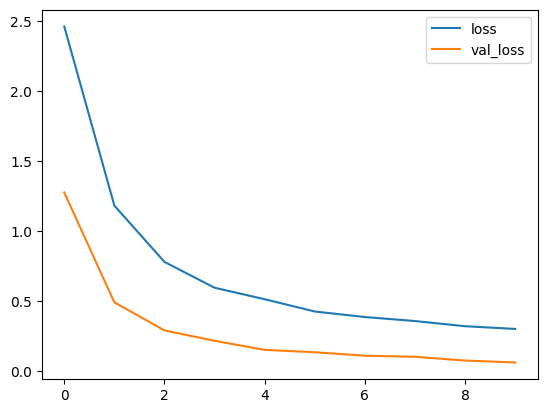

In [ ]:
evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

Next we will visualize the accuracy and loss per epoch. For this we will store the model history in the pandas dataframe and plot them.

In [ ]:
test_path = 'traffic_sign_dataset/Test'
!rm traffic_sign_dataset/Test/GT-final_test.csv

Creating the variable which has path of test dataset. As we downloded the dataset we found out that their is a GT-final_test.csv file in the test images folder which cannot be processed. So, we will remove that file.

In [ ]:
#defining a function that will scale images
from PIL import Image

def scaling(test_images, test_path):
    images = []

    image_path = test_images

    for x in image_path:
        img = Image.open(test_path + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)

    #Converting images into numpy array
    images = np.array(images)
    #The pixel value of each image ranges between 0 and 255
    #Dividing each image by 255 will scale the values between 0 and 1.
    images = images/255

    return images

next step would we creating a function to resize the test images converting them into a numpy array and normalize them.

In [ ]:
test_images = scaling(sorted(os.listdir(test_path)),test_path)

Calling the above created function on test images.



In [ ]:
test = pd.read_csv('traffic_sign_dataset/Test.csv')
y_test = test['ClassId'].values
y_test

array([16,  1, 38, ...,  6,  7, 10])

Next we will read label ids from Test.csv and store the values of the class id in y_test variable.

In [ ]:
y_pred_probabilities = model.predict(test_images)
y_pred_classes = y_pred_probabilities.argmax(axis=-1)

395/395 [==============================] - 1s 2ms/step


Now we will use the model to make predictions on our test images and save them in y_pred.

In [ ]:
# Storing all labels
all_labels = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']

Storing the labels according to the image classes.

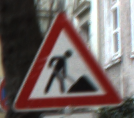

In [ ]:
# Visualize test image
img = Image.open(test_path + '/01152.png')
img

Let's visualize test image

In [ ]:
# Original label
print("Original label : ",all_labels[y_test[1152]])

Original label :  Road work


Finding out original label for the image above.

In [ ]:
# Predicted label
print("Predicted label : ",all_labels[y_pred_classes[1152]])

Predicted label :  Road work


Finding out the predicted label for the image above.

Conclusion:

Model reached an accuracy of 95%+ in just 10 epochs, we can further optimize the model using hyper parameter tuning and reach a higher accuracy.